### Compute IV-O2SLS

### TODO

- try different noises rand and randn -> understand what happens when you put everywhere rand and ground truth is worse that 2SLS and OLS
- try to implement the same but for bandits 
- why on cumulative regret when I plot it for the ground truth I dont see a straight line through zero? check that and check if the cumulative regret plots are sound.
- think if you can improve the the self-fulfilling bias term analysis by using Jensen and making the summation inside sqrt and trying to find a covariance between epsilon and eta
- find range of parameters where 2SLS is clearly better than OLS 

In [17]:
import numpy as np
from scipy.stats import t as t_law
import matplotlib.pyplot as plt
from tqdm import tqdm


colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']
s_colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

In [18]:
def sherman_morrison(invA, u, v):
    d = u.shape[0]
    u = u.reshape(d,1)
    v = v.reshape(d,1)
    return  (invA - (invA @ u @ v.T @ invA)/(1 + v.T @ invA @ u))

In [19]:
## PARAMETERS 
n_iters = 50
T = int(1e3)
sigma_1, sigma_2 = 1, 1
d, lamda, lamda_IV = 50, 1e-3, 1e-3 #lamdas[index_reg]  # coordinate dimension, regularization
methods = ['Ridge','O2SLS','Oracle']  # 'Oracle' is using the true parameter
online_loss = np.zeros((n_iters, len(methods), T))
np.random.seed(42)

theta_star = np.random.randn(d,d);  #theta_star *= 1/np.linalg.norm(theta_star)
# theta_star = np.eye(d,d)
beta_star = np.random.multivariate_normal([10],[[1]],d).reshape(-1,)
# print("beta = ", beta_star, "\ntheta = ", theta_star)

In [20]:
store_betas = np.zeros((len(methods), n_iters, d))

# Run
for it in tqdm(range(n_iters)):  # iterations to average the effect of noise
    
    # INITIALIZE
    thetas = np.zeros((len(methods),d,d))
    thetas[-1] = theta_star
    betas = np.zeros((len(methods),d))
    betas[-1] = beta_star
    GXXinv = np.eye(d)/lamda
    GZXinv = np.eye(d)/lamda_IV
    GZX = np.eye(d)*lamda_IV
    GXX = np.zeros((d,d))
    Zy = np.zeros(d)

    ## MODEL 
    # first stage
    Z = np.random.randn(T,d)
    eps = sigma_1*np.random.randn(T, d)
    # eps = np.zeros((T,d))
    X = np.dot(Z, theta_star) + eps
    # second stage
    eta_tilde = np.random.randn(T)
    # eta = eta_tilde + np.linalg.norm(eps, axis=1)  
    ee = d//4
    eta = sigma_2*(eta_tilde + eps[:,:ee].sum(axis=1))/(sigma_1*(ee+1)) 
    y = np.dot(X, beta_star) + eta

    # some bounds
    L_Z, L_X, L_y = max(np.linalg.norm(Z, axis=1)), max(np.linalg.norm(X, axis=1)), max(abs(y))  # signal level

    # start online regression for T rounds
    for t in range(T):
        z_t, x_t, y_t = Z[t], X[t], y[t]
        # update online losses
        online_loss[it, :, t] = (np.dot(betas, x_t) - y_t)**2

        ## RIDGE REGRESSION 
        update_beta_ridge = np.dot(GXXinv, np.dot(np.outer(x_t, x_t), betas[0]) - y_t*x_t) # G_{XX,t}^{-1} x_t x_t^T beta - y_t x_t
        if t<T-1:
            GXX += np.outer(x_t, x_t)
            _XGinvX = np.inner(X[t+1], np.dot(GXXinv, X[t+1]))  # x_{t+1}^T G_{XX,t}^{-1} x_{t+1}
            new_GXXinv = GXXinv - np.dot(GXXinv, np.dot(np.outer(X[t+1], X[t+1]), GXXinv))/(1+_XGinvX)  
        betas[0] -= update_beta_ridge  
        GXXinv = new_GXXinv

        ## IV-O2SLS expensive computation
        # _Z, _X, _y = Z[:t+1,:], X[:t+1,:], y[:t+1]
        # betas[1] = np.linalg.inv(_Z.T @ _X + 1e-10*np.eye(d)) @ _Z.T @ _y
        
        # GZX += np.outer(z_t, z_t)
        # GZXinv = sherman_morrison(GZXinv, z_t, x_t)
        # Zy += z_t * y_t
        # betas[1] = GZXinv @ Zy

        GZX += np.outer(z_t, x_t)
        if (t % 20 == 0):
            GZXinv = np.linalg.inv(GZX)
        else:
            GZXinv = sherman_morrison(GZXinv, z_t, x_t)
        Zy += z_t * y_t
        betas[1] = GZXinv @ Zy

    store_betas[0, it, :] = betas[0]
    store_betas[1, it, :] = betas[1]
    store_betas[2, it, :] = betas[2]

100%|██████████| 50/50 [00:25<00:00,  1.95it/s]


In [21]:
### Unstable ways to implement IV-O2SLS ###
        # update_beta_O2SLS = np.dot(GZXinv, np.dot(np.outer(z_t, x_t), betas[1]) - y_t*z_t)
        # if t<T-1:
        #     GZX += np.outer(z_t, x_t)
        #     _XGinvZ = np.inner(X[t+1], np.dot(GZXinv, Z[t+1]))  # z_{t+1}^T G_{XX,t}^{-1} x_{t+1}
        #     new_GZXinv = GZXinv - np.dot(GZXinv, np.dot(np.outer(X[t+1], Z[t+1]), GZXinv))/(1+_XGinvZ) 
        # betas[1] -= update_beta_O2SLS
        # GZXinv = new_GZXinv

        ### IV-O2SLS
        # update_beta_O2SLS = np.dot(GZXinv, np.dot(np.outer(z_t, x_t), betas[1]) - y_t*z_t)
        # if t == 0:
        #     new_GZXinv = np.linalg.inv(np.outer(z_t, x_t) + np.eye(d)*1e-10)
        #     # GZX += np.outer(z_t, x_t)
        # if 0<t<T-1:
        #     # GZX += np.outer(z_t, x_t)
        #     _XGinvZ = np.inner(X[t+1],np.dot(GZXinv, Z[t+1]))  # z_{t+1}^T G_{XX,t}^{-1} x_{t+1}
        #     new_GZXinv = GZXinv - np.dot(GZXinv, np.dot(np.outer(X[t+1], Z[t+1]), GZXinv))/(1+_XGinvZ) 
        # betas[1] -= update_beta_O2SLS
        # GZXinv = new_GZXinv

        ### IV-O2SLS
        # update_beta_O2SLS = np.dot(GZXinv, np.dot(np.outer(z_t, x_t), betas[1]) - y_t*z_t) # first piece is small second is big
        # lim = 999
        # if t < lim:
        #    GZX += np.outer(z_t, x_t)
        # if t == lim:
        #     GZXinv = np.linalg.inv(GZX + np.outer(z_t, x_t))
        # if lim<t<T-1:
        #     _XGinvZ = np.inner(X[t+1],np.dot(GZXinv, Z[t+1]))  # z_{t+1}^T G_{XX,t}^{-1} x_{t+1}
        #     new_GZXinv = GZXinv - np.dot(GZXinv, np.dot(np.outer(X[t+1], Z[t+1]), GZXinv))/(1+_XGinvZ) 
        #     GZXinv = new_GZXinv
        # betas[1] -= update_beta_O2SLS

In [22]:
# Here I make comparisons with mean values for different iterations and final estimates of beta

mean_beta_ridge = store_betas[0, :, :].mean(axis=0)
std_beta_ridge = store_betas[0, :, :].std(axis=0)
mean_beta_2SLS = store_betas[1, :, :].mean(axis=0)
std_beta_2SLS = store_betas[1, :, :].std(axis=0)
mean_beta_star = store_betas[2, :, :].mean(axis=0)
std_beta_star = store_betas[2, :, :].std(axis=0)

print("||beta - mean_s|| = ", round(np.linalg.norm(beta_star-mean_beta_star),4)) #, "\tbeta = ", beta_star, "\t\tstd=", std_beta_star)
print("||beta - mean_r|| = ", round(np.linalg.norm(beta_star-mean_beta_ridge),4)) #,  "\tbeta_r = ", betas[0], "\tstd=", std_beta_ridge)
print("||beta - mean_IV|| = ", round(np.linalg.norm(beta_star-mean_beta_2SLS),4)) #, "\tbeta_IV = ", betas[1], "\tstd=", std_beta_2SLS)
print("L_Z is: ", round(L_Z,4))
print("L_X is: ", round(L_X,4))
print("L_y is: ",round(L_y,4))
print("max |eta_t| is: ", max(abs(eta)))
print(methods)
print(np.sqrt(((betas-beta_star)**2).sum(axis=1)))

||beta - mean_s|| =  0.0
||beta - mean_r|| =  0.2468
||beta - mean_IV|| =  0.0045
L_Z is:  9.4703
L_X is:  78.2892
L_y is:  1801.4043
max |eta_t| is:  0.9393193614162645
['Ridge', 'O2SLS', 'Oracle']
[0.43849426 0.04580272 0.        ]


In [23]:
# here beta 

print("||beta|| = ", round(np.linalg.norm(beta_star),4))#, "\t\tbeta = ", beta_star)
print("||beta-mean_r|| = ", round(np.linalg.norm(beta_star-betas[0]),4))#,  "\tbeta_r = ", betas[0],)
print("||beta-mean_IV|| = ", round(np.linalg.norm(beta_star-betas[1]),4))#, "\tbeta_IV = ", betas[1])
print("L_Z is: ", round(L_Z,4))
print("L_X is: ", round(L_X,4))
print("L_y is: ",round(L_y,4))
print("max |eta_t| is: ", max(abs(eta)))
print(methods)
print(np.sqrt(((betas-beta_star)**2).sum(axis=1)))

||beta|| =  71.9595
||beta-mean_r|| =  0.4385
||beta-mean_IV|| =  0.0458
L_Z is:  9.4703
L_X is:  78.2892
L_y is:  1801.4043
max |eta_t| is:  0.9393193614162645
['Ridge', 'O2SLS', 'Oracle']
[0.43849426 0.04580272 0.        ]


In [24]:
# compute mean and std online losses
mean_online_loss = np.mean(online_loss, axis=0)
std_online_loss = np.std(online_loss, axis=0)

### Online Loss plots

We plot the  online loss $\left( \left\langle x_s, \beta_s^\bullet\right\rangle - y_s \right)^2 $ averarged over the iterations and where $\beta_s^\bullet$ is the Ridge or the 2SLS estimator:



In [56]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

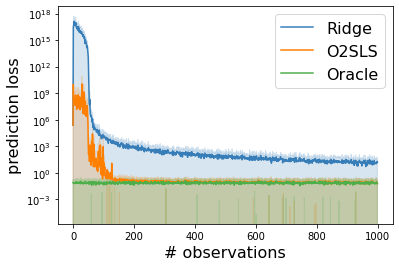

In [57]:
for i in range(len(methods)):
    plt.plot(np.arange(T), mean_online_loss[i], color=colors[i], label=methods[i])
    plt.fill_between(np.arange(T), mean_online_loss[i] - std_online_loss[i], mean_online_loss[i] + std_online_loss[i], color=s_colors[i],alpha=0.2)
plt.yscale('log')
# plt.xlim(-0.,50)
plt.xlabel("# observations")
plt.ylabel('prediction loss')
plt.legend()
plt.savefig("R_online_loss.pdf", format='pdf')

### Istantaneous Regret plots

We can also plot the difference with the ground truth estimator $\left( \left\langle x_t, \beta_t\right\rangle - y_t \right)^2 - \left( \left\langle x_t, \beta \right\rangle - y_t \right)^2
$

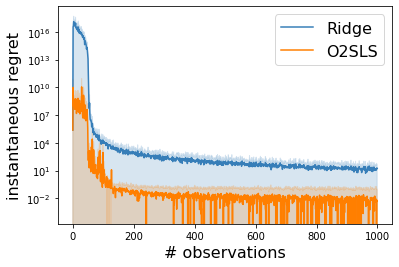

In [58]:
for i in range(len(methods)-1):
    plt.plot(mean_online_loss[i] - mean_online_loss[-1], color=colors[i], label=methods[i])
    plt.fill_between(np.arange(T), mean_online_loss[i] - mean_online_loss[-1] - std_online_loss[i], mean_online_loss[i]- mean_online_loss[-1] + std_online_loss[i], color=s_colors[i],alpha=0.2)
plt.yscale('log')
# plt.ylim(-10,10)
plt.legend()
plt.xlabel("# observations")
plt.ylabel('instantaneous regret')
plt.legend()
plt.savefig("R_instantaneous_regret.pdf", format='pdf')

### Cumulative Regret plots

The cumulative regret is instead:
$$
    \sum_{s=1}^t \left( \left\langle x_s, \beta_s\right\rangle - y_s \right)^2 - \sum_{s=1}^t \left( \left\langle x_s, \beta \right\rangle - y_s \right)^2
$$

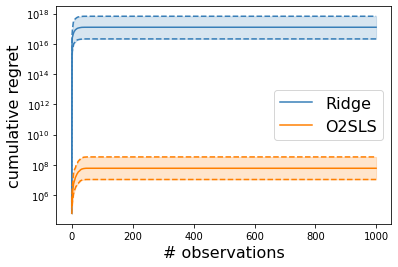

In [59]:
mean_cumulative_online_loss = np.cumsum(np.mean(online_loss, axis=0), axis=1) 
std_cumulative_online_loss = np.cumsum(np.std(online_loss, axis=0), axis=1) 

fst_quantile_online_loss = np.cumsum(np.quantile(online_loss,0.25,axis=0),axis=1)
scd_quantile_online_loss = np.cumsum(np.quantile(online_loss,0.5,axis=0),axis=1)
thd_quantile_online_loss = np.cumsum(np.quantile(online_loss,0.75,axis=0),axis=1)

for i in range(len(methods)-1):
    # plt.plot(np.arange(T), mean_cumulative_online_loss[i]-mean_cumulative_online_loss[-1], color=colors[i],label=methods[i])
    # plt.fill_between(np.arange(T), mean_cumulative_online_loss[i] - std_cumulative_online_loss[i]/10, mean_cumulative_online_loss[i] + std_cumulative_online_loss[i]/10, color=s_colors[i],alpha=0.2)   
    
    plt.fill_between(np.arange(T),fst_quantile_online_loss[i],thd_quantile_online_loss[i],color=colors[i],alpha=0.2)
    plt.plot(fst_quantile_online_loss[i],color=colors[i],linestyle="dashed")
    plt.plot(scd_quantile_online_loss[i],color=colors[i],linestyle="solid", label = methods[i])
    plt.plot(thd_quantile_online_loss[i],color=colors[i],linestyle="dashed") 

plt.yscale('log')
plt.legend()
plt.xlabel("# observations")
plt.ylabel('cumulative regret')
plt.legend()
plt.savefig("R_cumulative.pdf", format='pdf')

### Compute directly offline estimators

In [28]:
theta_star = np.eye(d,d)
beta_star = np.random.multivariate_normal([10],[[1]],d).reshape(-1,)
print("beta = ", beta_star, "\ntheta = ", theta_star)

beta =  [ 9.86025604 11.22852496 10.53983155 10.27135852 10.80486901  9.40807783
 10.39925327 10.33055417  9.82672705  9.96963952 11.95990959  9.95659068
  9.94571314 10.7796537  12.76177823  9.91793998 11.47920452 10.6983098
  9.63507316 11.315015   10.15503408  8.78789182 11.37134977 11.14526521
 10.59205437 11.39510176  8.94071967 10.21646805  9.04338814  9.14207418
 10.54170881  8.4804913   9.10023119 10.59375623  9.86050056 11.18015005
  8.00114402 11.06023232 11.59234234 11.51383587 10.53288106  9.68177164
 10.91564767 10.07271441 10.6366551   8.43411605 11.38937462 10.33933477
  9.81852919 10.46588685] 
theta =  [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [29]:
store_betas = np.zeros((len(methods), n_iters, d))

for it in range(n_iters):  # iterations to average the effect of noise
    
    # initialize
    thetas = np.zeros((len(methods),d,d))
    thetas[-1] = theta_star
    betas = np.zeros((len(methods),d))
    betas[-1] = beta_star

    # first stage
    Z = np.random.randn(T,d)
    eps = np.random.randn(T, d)
    # eps = np.zeros((T,d)) 
    X = np.dot(Z, theta_star) + eps
    # second stage
    eta_tilde = np.random.randn(T)
    # noise = eta_tilde + np.linalg.norm(eps, axis=1)  
    noise = eta_tilde + eps[:,0]
    y = np.dot(X, beta_star) + noise

    # z_t, x_t, y_t = Z[t], X[t], y[t]
    # online_loss[it, :, t] = (np.dot(betas, x_t) - y_t)**2        
    betas[0] = np.linalg.inv(X.T @ X) @ X.T @ y
    betas[1] = np.linalg.inv(Z.T @ X) @ Z.T @ y
    store_betas[0, it, :] = betas[0]
    store_betas[1, it, :] = betas[1]

In [30]:
mean_beta_ridge = store_betas[0, :, :].mean(axis=0)
std_beta_ridge = store_betas[0, :, :].std(axis=0)
mean_beta_2SLS = store_betas[1, :, :].mean(axis=0)
std_beta_2SLS = store_betas[1, :, :].std(axis=0)

print("||beta|| = ", round(np.linalg.norm(beta_star),4), "\t\tbeta = ", beta_star)
print("||beta-mean_r|| = ", round(np.linalg.norm(beta_star-mean_beta_ridge),4),  "\tbeta_r = ", betas[0], "\tstd=", std_beta_ridge)
print("||beta-mean_o|| = ", round(np.linalg.norm(beta_star-mean_beta_2SLS),4), "\tbeta_o = ", betas[1], "\tstd=", std_beta_2SLS)
print("L_Z is: ", round(L_Z,4))
print("L_X is: ", round(L_X,4))
print("L_y is: ",round(L_y,4))
print("max |eta_t| is: ", max(abs(noise)))
print(methods)
print(np.sqrt(((betas-beta_star)**2).sum(axis=1)))

||beta|| =  73.3001 		beta =  [ 9.86025604 11.22852496 10.53983155 10.27135852 10.80486901  9.40807783
 10.39925327 10.33055417  9.82672705  9.96963952 11.95990959  9.95659068
  9.94571314 10.7796537  12.76177823  9.91793998 11.47920452 10.6983098
  9.63507316 11.315015   10.15503408  8.78789182 11.37134977 11.14526521
 10.59205437 11.39510176  8.94071967 10.21646805  9.04338814  9.14207418
 10.54170881  8.4804913   9.10023119 10.59375623  9.86050056 11.18015005
  8.00114402 11.06023232 11.59234234 11.51383587 10.53288106  9.68177164
 10.91564767 10.07271441 10.6366551   8.43411605 11.38937462 10.33933477
  9.81852919 10.46588685]
||beta-mean_r|| =  0.5016 	beta_r =  [10.37227531 11.25531551 10.50693484 10.2785125  10.77654333  9.42216919
 10.37795449 10.37037475  9.83395683  9.98422013 11.95332004  9.97043853
  9.92784924 10.79189967 12.77596252  9.91598076 11.4644841  10.71342953
  9.62564998 11.32750804 10.1015839   8.77447916 11.40736934 11.13091596
 10.52438794 11.42540448  8.9690

### Graphs

In [31]:
mean_online_loss = np.mean(online_loss, axis=0)
# mean_online_regrets_reg[index_reg] = mean_online_loss[:-1]-mean_online_loss[-1]
std_online_loss = np.std(online_loss[:-1]-online_loss[-1], axis=0)
# std_online_regrets_reg[index_reg] = std_online_loss[:2,:]
# mean_test_loss = np.mean(test_loss, axis=0)
# std_test_loss = np.std(test_loss, axis=0)
# mean_fst_terms = np.mean(fst_terms, axis=0)
# mean_scd_terms = np.mean(scd_terms, axis=0)
# std_fst_terms = np.std(fst_terms, axis=0)
# std_scd_terms = np.std(scd_terms, axis=0)

Text(0.5, 1.0, 'xps/OnlineRegret_BetaNorm=73.3')

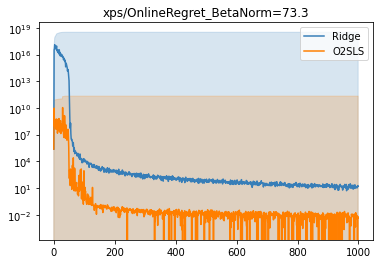

In [32]:
for i in range(len(methods)-1):
    plt.plot(mean_online_loss[i]-mean_online_loss[-1], color=colors[i],label=methods[i])
    plt.fill_between(np.arange(T),np.cumsum(mean_online_loss[i])-np.cumsum(std_online_loss[i]),np.cumsum(mean_online_loss[i])+np.cumsum(std_online_loss[i]), color=s_colors[i],alpha=0.2)   
    # plt.plot(np.cumsum(mean_online_loss[i]+mean_scd_terms[i]),color=colors[i],linestyle='dotted')
    plt.yscale('log')
# plt.xlim(-0.,50)
plt.legend()
title = "xps/OnlineRegret_BetaNorm="+str(round(np.linalg.norm(beta_star),2))
plt.title(title)
# plt.savefig(title+'.pdf',bbox_inches='tight')